### ***DATA GENERATION***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


In [2]:
def make_grid(n=64, scale=1.0):
    x = np.linspace(-scale, scale, n)
    y = np.linspace(-scale, scale, n)
    return np.meshgrid(x, y)

X, Y = make_grid()



In [3]:
def sersic_source(x, y, x0=0.1, y0=-0.05, r_eff=0.25, n=1.5):
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    return np.exp(-(r / r_eff)**(1/n))


In [4]:
def sis_deflection(x, y, theta_E=0.6):
    r = np.sqrt(x**2 + y**2) + 1e-6
    alpha_x = theta_E * x / r
    alpha_y = theta_E * y / r
    return alpha_x, alpha_y


In [5]:
def cdm_perturbation(x, y, n_halos=6):
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    for _ in range(n_halos):
        x0, y0 = np.random.uniform(-0.5, 0.5, 2)
        strength = np.random.uniform(0.02, 0.05)
        r = np.sqrt((x-x0)**2 + (y-y0)**2) + 1e-3
        ax += strength * (x-x0)/r
        ay += strength * (y-y0)/r
    return ax, ay


In [6]:
def axion_perturbation(x, y, k=10, amp=0.03):
    ax = amp * np.sin(k * x)
    ay = amp * np.sin(k * y)
    return ax, ay


In [7]:
def generate_lens_image(mode="NO_SUB"):
    X, Y = make_grid()

    # Base lens
    ax, ay = sis_deflection(X, Y)

    # Add substructure
    if mode == "CDM":
        dax, day = cdm_perturbation(X, Y)
        ax += dax
        ay += day

    if mode == "AXION":
        dax, day = axion_perturbation(X, Y)
        ax += dax
        ay += day

    # Ray tracing
    beta_x = X - ax
    beta_y = Y - ay

    img = sersic_source(beta_x, beta_y)

    # PSF + noise
    img = gaussian_filter(img, sigma=1.0)
    img += np.random.normal(0, 0.02, img.shape)

    # Normalize
    img -= img.min()
    img /= img.max()

    return img


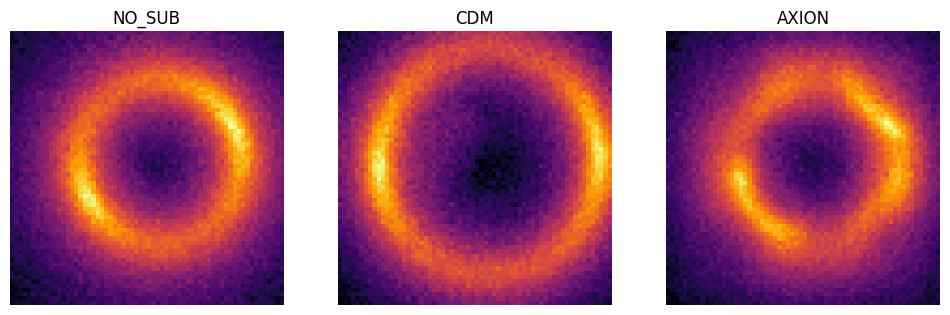

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

for ax, mode in zip(axes, ["NO_SUB", "CDM", "AXION"]):
    img = generate_lens_image(mode)
    ax.imshow(img, cmap="inferno")
    ax.set_title(mode)
    ax.axis("off")

plt.show()


### ***DATASET LOADING + EXPLORATION***

In [9]:
import os

base_path = "/content/drive/MyDrive/Project GSoC/dark_matter_lensing/data/raw"

for cls in ["NO_SUB", "CDM", "AXION"]:
    print(cls, ":", len(os.listdir(os.path.join(base_path, cls))))


NO_SUB : 500
CDM : 500
AXION : 500


In [11]:
# Create PyTorch Dataset

import torch
from torch.utils.data import Dataset
import numpy as np

class LensingDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.label_map = {
            "NO_SUB": 0,
            "CDM": 1,
            "AXION": 2
        }

        for cls, label in self.label_map.items():
            cls_path = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_path):
                if fname.endswith(".npy"):
                    self.samples.append(
                        (os.path.join(cls_path, fname), label)
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = np.load(path).astype("float32")

        # add channel dimension
        img = torch.tensor(img).unsqueeze(0)

        return img, label


In [12]:
# Instantiate Dataset

dataset = LensingDataset(base_path)
print("Total samples:", len(dataset))


Total samples: 1500


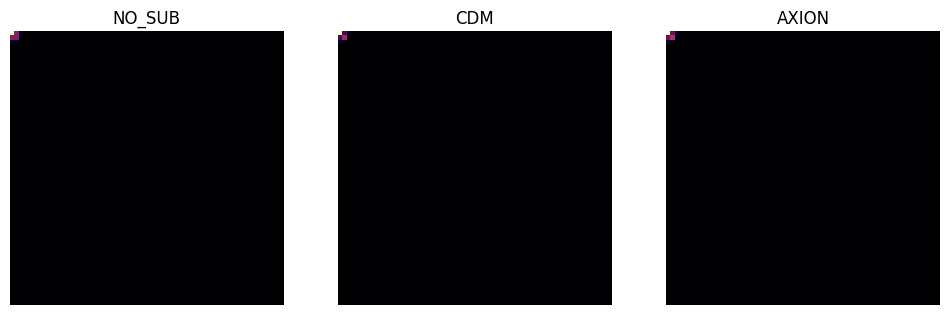

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12,4))

for ax, cls in zip(axes, ["NO_SUB", "CDM", "AXION"]):
    idx = next(i for i,(p,l) in enumerate(dataset.samples) if cls in p)
    img, _ = dataset[idx]

    ax.imshow(img.squeeze(), cmap="inferno", vmin=0, vmax=1)
    ax.set_title(cls)
    ax.axis("off")

plt.show()


In [25]:
img, label = dataset[0]

print("min:", img.min().item())
print("max:", img.max().item())
print("mean:", img.mean().item())
print("non-zero pixels:", (img > 0).sum().item())


min: 0.0
max: 1.0
mean: 0.001202884130179882
non-zero pixels: 4095


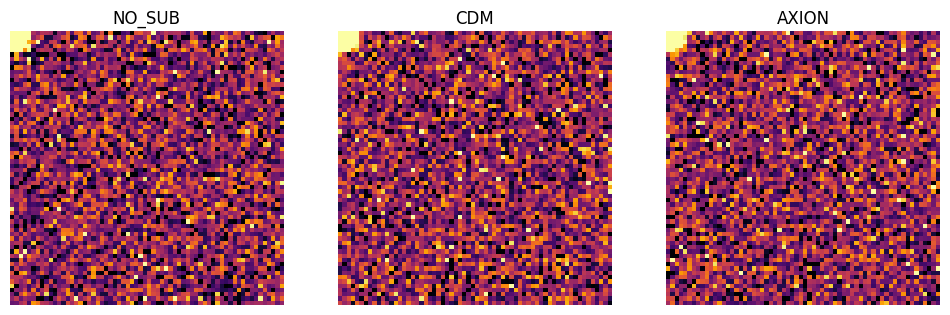

In [27]:
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(12,4))

for ax, cls in zip(axes, ["NO_SUB", "CDM", "AXION"]):
    idx = next(i for i,(p,l) in enumerate(dataset.samples) if cls in p)
    img, _ = dataset[idx]
    img = img.squeeze().numpy()

    vmin = np.percentile(img, 5)
    vmax = np.percentile(img, 99)

    ax.imshow(img, cmap="inferno", vmin=vmin, vmax=vmax)
    ax.set_title(cls)
    ax.axis("off")

plt.show()


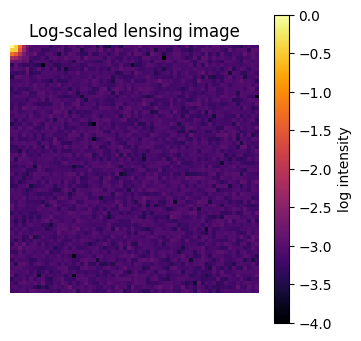

In [26]:
import numpy as np
import matplotlib.pyplot as plt

img, _ = dataset[0]
img = img.squeeze().numpy()

plt.figure(figsize=(4,4))
plt.imshow(np.log10(img + 1e-4), cmap="inferno")
plt.colorbar(label="log intensity")
plt.title("Log-scaled lensing image")
plt.axis("off")
plt.show()


In [16]:
import os

base_path = "/content/drive/MyDrive/Project GSoC/dark_matter_lensing/data/raw"

for cls in ["NO_SUB", "CDM", "AXION"]:
    print(cls, ":", len(os.listdir(os.path.join(base_path, cls))))


NO_SUB : 500
CDM : 500
AXION : 500


In [29]:
# Train / Validation Split

from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(len(train_dataset), len(val_dataset))


1200 300


In [30]:
# DataLoaders

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


### ***CNN MODEL AND TRAINING***

In [31]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [32]:
# Baseline CNN Model

class BaselineCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 32x32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [33]:
# Initialize Model, Loss, Optimizer

model = BaselineCNN(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [34]:
# Training Loop

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


In [35]:
# Validation loop

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [36]:
# Train the model

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}"
    )


Epoch 01 | Train Loss: 1.1010, Train Acc: 0.338 | Val Loss: 1.0995, Val Acc: 0.303
Epoch 02 | Train Loss: 1.0895, Train Acc: 0.406 | Val Loss: 1.0552, Val Acc: 0.330
Epoch 03 | Train Loss: 0.8736, Train Acc: 0.645 | Val Loss: 0.5757, Val Acc: 0.980
Epoch 04 | Train Loss: 0.3950, Train Acc: 0.920 | Val Loss: 0.2381, Val Acc: 0.980
Epoch 05 | Train Loss: 0.2322, Train Acc: 0.940 | Val Loss: 0.1604, Val Acc: 0.970
Epoch 06 | Train Loss: 0.1854, Train Acc: 0.950 | Val Loss: 0.1604, Val Acc: 0.980
Epoch 07 | Train Loss: 0.1743, Train Acc: 0.956 | Val Loss: 0.1387, Val Acc: 0.957
Epoch 08 | Train Loss: 0.1728, Train Acc: 0.962 | Val Loss: 0.1404, Val Acc: 0.973
Epoch 09 | Train Loss: 0.1628, Train Acc: 0.956 | Val Loss: 0.1264, Val Acc: 0.973
Epoch 10 | Train Loss: 0.1540, Train Acc: 0.960 | Val Loss: 0.1550, Val Acc: 0.953


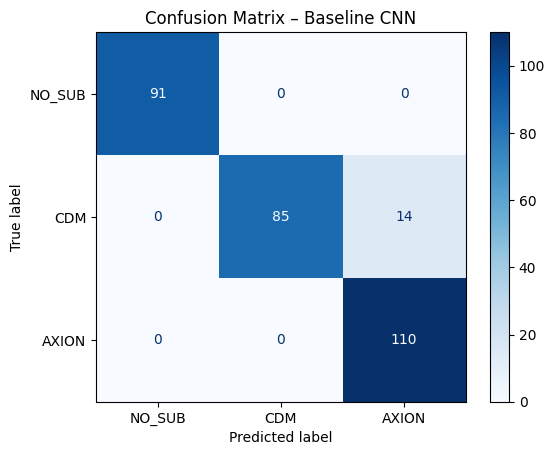

20

In [37]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["NO_SUB", "CDM", "AXION"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Baseline CNN")
plt.show()
20

### ***TRAINING CURVES & OVERFITTING ANALYSIS***

In [38]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

num_epochs = 15

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}"
    )


Epoch 01 | Train Loss: 0.1476, Train Acc: 0.961 | Val Loss: 0.1414, Val Acc: 0.980
Epoch 02 | Train Loss: 0.1450, Train Acc: 0.965 | Val Loss: 0.1125, Val Acc: 0.973
Epoch 03 | Train Loss: 0.1442, Train Acc: 0.967 | Val Loss: 0.1227, Val Acc: 0.980
Epoch 04 | Train Loss: 0.1389, Train Acc: 0.964 | Val Loss: 0.1049, Val Acc: 0.977
Epoch 05 | Train Loss: 0.1337, Train Acc: 0.967 | Val Loss: 0.1017, Val Acc: 0.977
Epoch 06 | Train Loss: 0.1232, Train Acc: 0.968 | Val Loss: 0.1115, Val Acc: 0.980
Epoch 07 | Train Loss: 0.1167, Train Acc: 0.968 | Val Loss: 0.1139, Val Acc: 0.963
Epoch 08 | Train Loss: 0.1250, Train Acc: 0.967 | Val Loss: 0.1017, Val Acc: 0.980
Epoch 09 | Train Loss: 0.1583, Train Acc: 0.956 | Val Loss: 0.0991, Val Acc: 0.973
Epoch 10 | Train Loss: 0.1204, Train Acc: 0.968 | Val Loss: 0.0969, Val Acc: 0.973
Epoch 11 | Train Loss: 0.1266, Train Acc: 0.966 | Val Loss: 0.1027, Val Acc: 0.980
Epoch 12 | Train Loss: 0.1035, Train Acc: 0.975 | Val Loss: 0.1031, Val Acc: 0.980
Epoc

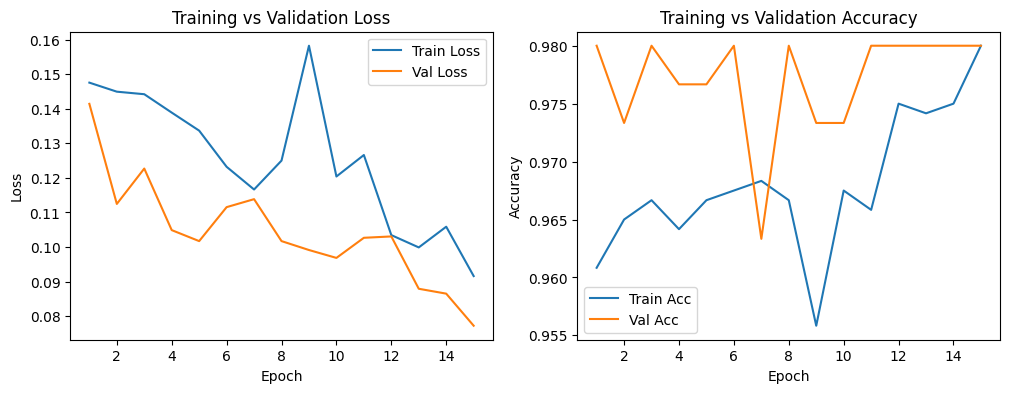

In [39]:
# Plot training curves

import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()


### ***PHYSICS-INFORMED RESIDUAL CHANNEL***

In [40]:
# Compute residual map

from scipy.ndimage import gaussian_filter

def compute_residual(img, sigma=2.0):
    smooth = gaussian_filter(img, sigma=sigma)
    residual = img - smooth
    return residual


In [41]:
# Modify Dataset → 2 channels

def __getitem__(self, idx):
    path, label = self.samples[idx]
    img = np.load(path).astype("float32")

    residual = compute_residual(img)

    # stack as 2 channels
    img = torch.tensor(img)
    residual = torch.tensor(residual)

    x = torch.stack([img, residual], dim=0)  # (2, 64, 64)

    return x, label


In [43]:
# Update CNN to accept 2 channels

class PhysicsInformedCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),  # 2 input channels
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 32x32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



### ***DATA AUGMENTATION & REGULARIZATION***

In [45]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, use_residual=False, augment=False):
        self.samples = []
        self.use_residual = use_residual
        self.augment = augment

        self.label_map = {"NO_SUB": 0, "CDM": 1, "AXION": 2}

        for cls, label in self.label_map.items():
            cls_path = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_path):
                if fname.endswith(".npy"):
                    self.samples.append((os.path.join(cls_path, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = np.load(path).astype("float32")

        if self.use_residual:
            residual = compute_residual(img)
            img = torch.tensor(img)
            residual = torch.tensor(residual)
            x = torch.stack([img, residual], dim=0)  # (2,64,64)
        else:
            x = torch.tensor(img).unsqueeze(0)  # (1,64,64)

        # ✅ ON-THE-FLY DATA AUGMENTATION (CORRECT PLACE)
        if self.augment:
            if torch.rand(1).item() > 0.5:
                x = torch.flip(x, dims=[2])  # horizontal flip
            if torch.rand(1).item() > 0.5:
                x = torch.flip(x, dims=[1])  # vertical flip

        return x, label


In [46]:
dataset_aug = LensingDataset(
    base_path, use_residual=True, augment=True
)

x, y = dataset_aug[0]
print(x.shape)


torch.Size([2, 64, 64])


In [47]:
train_dataset = LensingDataset(
    base_path, use_residual=True, augment=True
)
val_dataset = LensingDataset(
    base_path, use_residual=True, augment=False
)


In [48]:
baseline_train = LensingDataset(
    base_path, use_residual=False, augment=False
)
baseline_val = LensingDataset(
    base_path, use_residual=False, augment=False
)

train_size = int(0.8 * len(baseline_train))
val_size = len(baseline_train) - train_size

baseline_train, _ = torch.utils.data.random_split(
    baseline_train, [train_size, val_size]
)
_, baseline_val = torch.utils.data.random_split(
    baseline_val, [train_size, val_size]
)

train_loader_base = DataLoader(baseline_train, batch_size=32, shuffle=True)
val_loader_base = DataLoader(baseline_val, batch_size=32, shuffle=False)


In [49]:
model_base = BaselineCNN().to(device)
optimizer = optim.Adam(model_base.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

base_train_accs, base_val_accs = [], []

for epoch in range(10):
    _, train_acc = train_one_epoch(
        model_base, train_loader_base, optimizer, criterion
    )
    _, val_acc = evaluate(
        model_base, val_loader_base, criterion
    )
    base_train_accs.append(train_acc)
    base_val_accs.append(val_acc)

    print(f"[Baseline] Epoch {epoch+1}: "
          f"Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")


[Baseline] Epoch 1: Train Acc=0.322, Val Acc=0.333
[Baseline] Epoch 2: Train Acc=0.342, Val Acc=0.333
[Baseline] Epoch 3: Train Acc=0.527, Val Acc=0.960
[Baseline] Epoch 4: Train Acc=0.874, Val Acc=0.917
[Baseline] Epoch 5: Train Acc=0.938, Val Acc=0.950
[Baseline] Epoch 6: Train Acc=0.953, Val Acc=0.953
[Baseline] Epoch 7: Train Acc=0.960, Val Acc=0.940
[Baseline] Epoch 8: Train Acc=0.953, Val Acc=0.920
[Baseline] Epoch 9: Train Acc=0.964, Val Acc=0.943
[Baseline] Epoch 10: Train Acc=0.961, Val Acc=0.970


In [50]:
phys_train = LensingDataset(
    base_path, use_residual=True, augment=True
)
phys_val = LensingDataset(
    base_path, use_residual=True, augment=False
)

phys_train, _ = torch.utils.data.random_split(
    phys_train, [train_size, val_size]
)
_, phys_val = torch.utils.data.random_split(
    phys_val, [train_size, val_size]
)

train_loader_phys = DataLoader(phys_train, batch_size=32, shuffle=True)
val_loader_phys = DataLoader(phys_val, batch_size=32, shuffle=False)


In [51]:
model_phys = PhysicsInformedCNN().to(device)
optimizer = optim.Adam(model_phys.parameters(), lr=5e-4)

phys_train_accs, phys_val_accs = [], []

for epoch in range(10):
    _, train_acc = train_one_epoch(
        model_phys, train_loader_phys, optimizer, criterion
    )
    _, val_acc = evaluate(
        model_phys, val_loader_phys, criterion
    )
    phys_train_accs.append(train_acc)
    phys_val_accs.append(val_acc)

    print(f"[Physics] Epoch {epoch+1}: "
          f"Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")


[Physics] Epoch 1: Train Acc=0.552, Val Acc=0.330
[Physics] Epoch 2: Train Acc=0.877, Val Acc=0.677
[Physics] Epoch 3: Train Acc=0.927, Val Acc=0.987
[Physics] Epoch 4: Train Acc=0.932, Val Acc=0.653
[Physics] Epoch 5: Train Acc=0.940, Val Acc=0.980
[Physics] Epoch 6: Train Acc=0.949, Val Acc=0.657
[Physics] Epoch 7: Train Acc=0.927, Val Acc=0.933
[Physics] Epoch 8: Train Acc=0.968, Val Acc=0.983
[Physics] Epoch 9: Train Acc=0.958, Val Acc=0.987
[Physics] Epoch 10: Train Acc=0.970, Val Acc=0.980


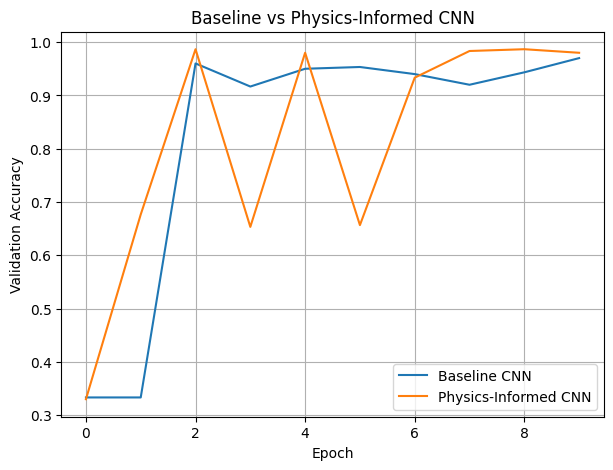

In [52]:
plt.figure(figsize=(7,5))

plt.plot(base_val_accs, label="Baseline CNN")
plt.plot(phys_val_accs, label="Physics-Informed CNN")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Baseline vs Physics-Informed CNN")
plt.legend()
plt.grid()
plt.show()


In [53]:
def get_predictions(model, loader):
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            labels.extend(y.numpy())
    return labels, preds


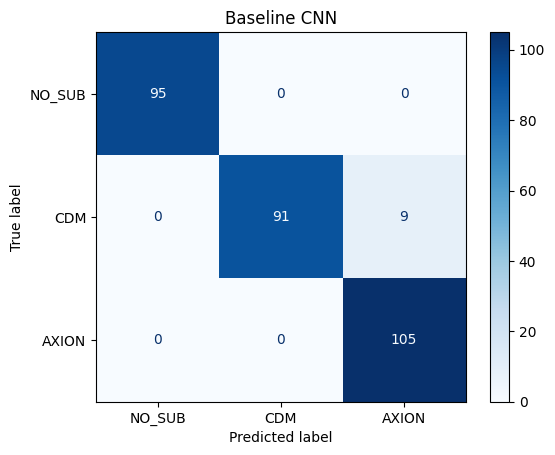

In [54]:
y_true, y_pred = get_predictions(model_base, val_loader_base)
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_true, y_pred),
    display_labels=["NO_SUB","CDM","AXION"]
).plot(cmap="Blues")
plt.title("Baseline CNN")
plt.show()


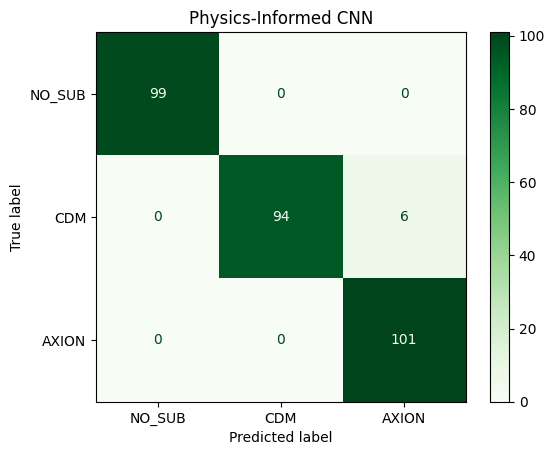

In [55]:
y_true, y_pred = get_predictions(model_phys, val_loader_phys)
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_true, y_pred),
    display_labels=["NO_SUB","CDM","AXION"]
).plot(cmap="Greens")
plt.title("Physics-Informed CNN")
plt.show()
